# **Connecting Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Statistical Comparison of Models' RMSE Value**

# **Importing Libraries**

In [4]:
# Install required packages
!pip install scikit-posthocs orange3 matplotlib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.3/270.3 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/

In [6]:
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare
import matplotlib.pyplot as plt
import seaborn as sns

### **Data Loading**

In [7]:
# File path to CSV in Google Drive
file_path = "/content/drive/My Drive/LST_RMSE.csv"
# Load the CSV
df = pd.read_csv(file_path)
# Drop the State column (only keep model RMSEs)
data = df.drop(columns=["State"])

# **Friedman Test**

In [8]:
stat, p = friedmanchisquare(data["CurveFit"], data["ExpSmooth"], data["Forest"])
print("Friedman Chi-Square statistic:", stat)
print("p-value:", p)

if p < 0.05:
    print("Reject Null Hypothesis: At least one model performs significantly different.")
else:
    print("Fail to Reject Null Hypothesis: No significant difference among models.")


Friedman Chi-Square statistic: 47.18918918918922
p-value: 5.6623637479071e-11
Reject Null Hypothesis: At least one model performs significantly different.


# **Nemenyi Post-hoc Test**

In [9]:
import scikit_posthocs as sp

nemenyi = sp.posthoc_nemenyi_friedman(data.values)
nemenyi.index = data.columns
nemenyi.columns = data.columns

print("\nNemenyi Post-hoc Test (p-values):")
print(nemenyi)



Nemenyi Post-hoc Test (p-values):
               CurveFit  ExpSmooth        Forest
CurveFit   1.000000e+00   0.000003  1.033806e-10
ExpSmooth  3.132864e-06   1.000000  1.890051e-01
Forest     1.033806e-10   0.189005  1.000000e+00


# **Visualizing Result**

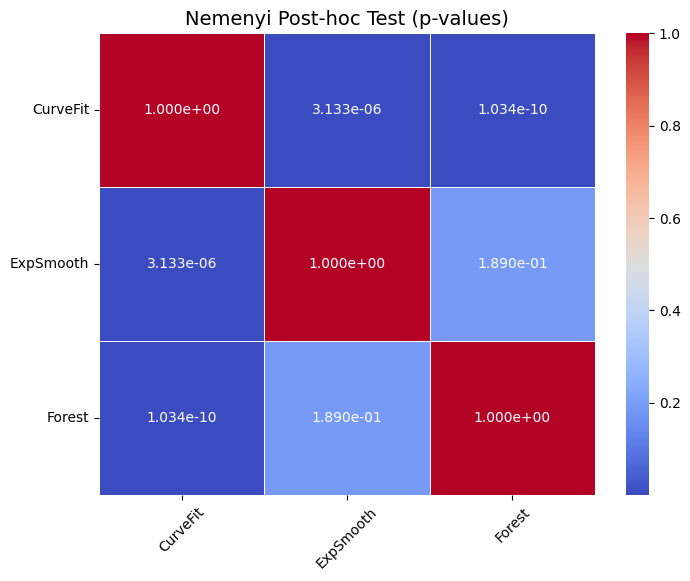

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Nemenyi heatmap with scientific notation
plt.figure(figsize=(8,6))
ax = sns.heatmap(
    nemenyi,
    annot=True,
    fmt=".3e",   # 🔑 force scientific notation (e.g., 1.03e-10)
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5
)

plt.title("Nemenyi Post-hoc Test (p-values)", fontsize=14)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()


# **Critical Difference Calculation**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define average ranks of your models

models = ["CurveFit", "ExpSmooth", "Forest"]
avg_ranks = data.rank(axis=1, method='average').mean().values

# Sort by rank (smaller rank = better performance)
order = np.argsort(avg_ranks)
models = [models[i] for i in order]
avg_ranks = [avg_ranks[i] for i in order]

# Critical Difference (CD) calculation
# For Friedman + Nemenyi, CD depends on k (models) and N (datasets)

import math

k = len(models)        # number of models
N = len(data)          # number of datasets (states)
q_alpha = 2.343        # critical value for k=3, alpha=0.05 (from Nemenyi table)
CD = q_alpha * math.sqrt(k*(k+1)/(6*N))

print(f"Critical Difference (CD): {CD:.3f}")

Critical Difference (CD): 0.545


# Visualize CD

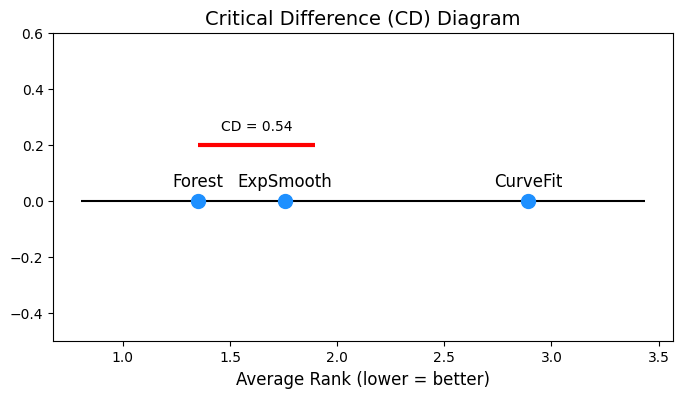

In [ ]:
plt.figure(figsize=(8, 4))
y = np.zeros_like(avg_ranks)

# Plot average ranks as points
plt.scatter(avg_ranks, y, s=100, color="dodgerblue", zorder=3)

# Add model labels
for (x, m) in zip(avg_ranks, models):
    plt.text(x, 0.05, m, ha="center", fontsize=12)

# Draw horizontal axis (rank scale)
plt.hlines(0, min(avg_ranks)-CD, max(avg_ranks)+CD, colors="black")
plt.xlabel("Average Rank (lower = better)", fontsize=12)

# Show CD bar at top
plt.hlines(0.2, min(avg_ranks), min(avg_ranks)+CD, colors="red", linewidth=3)
plt.text(min(avg_ranks)+CD/2, 0.25, f"CD = {CD:.2f}", ha="center", fontsize=10)

plt.title("Critical Difference (CD) Diagram", fontsize=14)
plt.ylim(-0.5, 0.6)
plt.show()
